## In this notebook: Fig 6E, Fig S6, Fig S7

In [96]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import mne

import glob
import os
import sys
from scipy.io import savemat, loadmat
from scipy.stats import pearsonr, spearmanr, sem
from statsmodels.stats.multitest import fdrcorrection
import scipy.stats as stats
from pingouin import rm_anova

import matplotlib as mpl
plt.style.use("article.mplstyle")

from statannotations.Annotator import Annotator


sys.path.append('../utils')
from ERP_utils import *
from update_sub_lists import*
from plot_utils import *
mne.set_log_level('CRITICAL')

### Set up 

In [97]:
#plotting parameters
firsts_color = 'teal'
others_color = 'coral'



In [98]:
#-----------------------------
#           LOADING FILES AND INITIALIZING DIRECTORIES
#-----------------------------

#use MIDI folders or audio folders to change triggers
epochs_dir = '../analysis_error/error_epochs_data_n05to05_30Hz_corrected'


#channels and times for plotting
# ch_names_64, ch_names_72 = load_channels()
erp_times = create_erp_times(-0.5,0.5, 128)

good_listen_subjects, good_motor_subjects, good_error_subjects, musicians, nonmusicians = load_subject_lists_LME()
subjects_to_process =  good_error_subjects


In [99]:
def load_error_epochs_bysubject(epochs_dir, subjects_to_process, epoch_type, sub_ave = True):
    """ 
    Loads the epochs for error trials
    subjects_to_process: list of subjects where each element is a string. e.g. ['01', '02']
    epoch_type: which error keystrokes are included. Currently 'all', 'inv', 'shinv' and 'norm'
        ---future: separate keystrokes that are the first keystroke after a map change from all the other keystrokes
    sub_ave: averages over channels
    ---
    Returns a dataframe with columns 'subject', 'period', 'musician', and 'epoch_type'.
        each row of ['epochs'] is an array of shape n_channels x n_timepoints, and is the average of all epochs from one subject
    
    """

    epochs_df = pd.DataFrame(columns = ['subject', 'period', 'musician', 'epochtype', 'epochs'])
    good_listen_subjects, good_motor_subjects, musicians, nonmusicians = load_subject_lists()

    assert isinstance (subjects_to_process, list)

    for subject in subjects_to_process:
        print('Processing subject: ', subject)

        if subject in musicians: 
            musician = 1
        else: 
            musician = 0
        for period in ['pre', 'post']:
            file_epochs_pre = glob.glob(os.path.join(epochs_dir, f'error_epochs_{epoch_type}_{period}_{subject}.fif'))[0]
            epochs_sub = mne.read_epochs(file_epochs_pre)

            if sub_ave:
                epochs_sub = np.mean(epochs_sub.get_data()[:, :64, :], axis = 0) #get only the eeg channels and average all trials per subject
            else: 
                #epochs_sub = epochs_sub.get_data()[:, :64, :]
                epochs_sub = epochs_sub.get_data()

            df_sub = pd.DataFrame({
                'subject': subject,
                'period' : period,
                'musician' : musician,
                'epochtype': epoch_type,
                'epochs': [epochs_sub]
            })
            epochs_df = pd.concat([epochs_df, df_sub])


    epochs_df.reset_index(drop=True, inplace=True)
    return (epochs_df)


In [100]:
epochs_df_all = load_error_epochs_bysubject(epochs_dir, subjects_to_process, 'all', sub_ave=False)
epochs_df_inv = load_error_epochs_bysubject(epochs_dir, subjects_to_process, 'inv', sub_ave = False)
epochs_df_shinv = load_error_epochs_bysubject(epochs_dir, subjects_to_process, 'shinv', sub_ave = False)
epochs_df_norm = load_error_epochs_bysubject(epochs_dir, subjects_to_process, 'norm', sub_ave = False)

epochs_df_firsts = load_error_epochs_bysubject(epochs_dir, subjects_to_process, 'firsts', sub_ave=False)
epochs_df_others = load_error_epochs_bysubject(epochs_dir, subjects_to_process, 'others', sub_ave=False)


Processing subject:  01
Processing subject:  04
Processing subject:  05
Processing subject:  06
Processing subject:  07
Processing subject:  08
Processing subject:  09
Processing subject:  10
Processing subject:  11
Processing subject:  12
Processing subject:  13
Processing subject:  14
Processing subject:  15
Processing subject:  16
Processing subject:  17
Processing subject:  18
Processing subject:  19
Processing subject:  20
Processing subject:  01
Processing subject:  04
Processing subject:  05
Processing subject:  06
Processing subject:  07
Processing subject:  08
Processing subject:  09
Processing subject:  10
Processing subject:  11
Processing subject:  12
Processing subject:  13
Processing subject:  14
Processing subject:  15
Processing subject:  16
Processing subject:  17
Processing subject:  18
Processing subject:  19
Processing subject:  20
Processing subject:  01
Processing subject:  04
Processing subject:  05
Processing subject:  06
Processing subject:  07
Processing subje

In [101]:
def find_evokeds(epochs_df, column_to_ave = 'epochs', ev_col_name = 'evokeds'):
    """ 
    Takes a dataframe with columns 'subject', 'period', 'musician', 'epochtype', 'epochs'
    Returns mean and sem of epochs for each subject
    """
    #if 'evokeds' not in epochs_df.columns:
    epochs_df[ev_col_name] = epochs_df[column_to_ave].apply(lambda x: np.mean(x, axis = 0))
    return epochs_df

def find_mean_sem_eps(epochs_df, ch_idx, col_to_ave = 'epochs'):
    """ 
    Takes a dataframe with columns 'subject', 'period', 'musician', 'epochtype', 'epochs'
    Returns mean and sem of epochs for each subject
    """
    if col_to_ave == 'epochs' and 'evokeds' not in epochs_df.columns:
        epochs_df['evokeds'] = epochs_df[col_to_ave].apply(lambda x: np.mean(x, axis = 0))
        mean_ev = epochs_df['evokeds'].mean(axis=0)[ch_idx].flatten()   
        sem_ev = sem(epochs_df['evokeds'],axis=0)[ch_idx].flatten()
    
    else:
        epochs_df[col_to_ave+'_evokeds'] = epochs_df[col_to_ave].apply(lambda x: np.mean(x, axis = 0))
        mean_ev = epochs_df[col_to_ave+'evokeds'].mean(axis=0)[ch_idx].flatten()   
        sem_ev = sem(epochs_df[col_to_ave+'evokeds'],axis=0)[ch_idx].flatten()

    return mean_ev, sem_ev
    


def find_mean_sem_eps(epochs_df, ch_idx, col_to_ave='epochs', data = 'epochs'):
    """ 
    Takes a dataframe with columns 'subject', 'period', 'musician', 'epochtype', 'epochs'
    Returns mean and sem of epochs for each subject
    """
    # evoked_col = f'{col_to_ave}_evokeds'
    
    if 'evokeds' not in epochs_df.columns:

        epochs_df['evokeds'] = epochs_df[col_to_ave].apply(lambda x: np.mean(x, axis=0))
    
    mean_ev = epochs_df['evokeds'].mean(axis=0)[ch_idx].flatten()
    sem_ev = sem(np.stack(epochs_df['evokeds'].values), axis=0)[ch_idx].flatten()
    
    return mean_ev, sem_ev

def find_mean_sem_evs(epochs_df, ch_idx, col_to_ave):
    mean_ev = epochs_df[col_to_ave].mean(axis=0)[ch_idx].flatten()
    sem_ev = sem(np.stack(epochs_df[col_to_ave].values), axis=0)[ch_idx].flatten()
    
    return mean_ev, sem_ev

def plot_mean_sem(times, mean, sem, color, label):
    plt.plot(times, mean, color=color, label=label)
    plt.fill_between(times, mean - sem, mean + sem, color=color, alpha=0.3)


def config_erp_plot(axis_fontsize=20, tick_fontsize=15, linewidth = 1):
    plt.xlabel('Time (s)', fontsize=axis_fontsize)
    plt.ylabel('Amplitude (µV)', fontsize=axis_fontsize)
   
    
    # Draw reference lines
    plt.hlines(0, -0.5, 0.5, color='black', linewidth=linewidth)
    plt.vlines(0, -6.5e-6, 5e-6, color='black', linewidth=linewidth)
    
    # Format y-axis values in µV instead of scientific notation
    plt.ticklabel_format(style='plain', axis='y')
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x * 1e6:.1f}'))
    
    # Set axis limits
    plt.xlim(-0.1, 0.45)
    plt.ylim(-6.5e-6, 5e-6)
    
    # Set tick font sizes
    plt.xticks(fontsize=tick_fontsize)
    plt.yticks(fontsize=tick_fontsize)
    
def peak_regions_max(x, ch_idx, t_idx):
    x_ch_mean = np.mean(x[ch_idx], axis =0)
    x_ch_time_max = np.max(x_ch_mean[t_idx[0]:t_idx[1]])
    return x_ch_time_max

def peak_regions_min(x, ch_idx, t_idx):
    x_ch_mean = np.mean(x[ch_idx], axis =0)
    x_ch_time_max = np.min(x_ch_mean[t_idx[0]:t_idx[1]])
    return x_ch_time_max


def peak_regions_custom(x, ch_idx, t_idx, peak_type):
    x_ch_mean = np.mean(x[ch_idx], axis =0)
    x_ch_time_peak = peak_type(x_ch_mean[t_idx[0]:t_idx[1]])
    return x_ch_time_peak

## Fig S6: ERPs by map

/var/folders/jq/t9k2fgpx515flrs5403k2gf80000gn/T/ipykernel_59670/143457862.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  epochs_df['evokeds'] = epochs_df[col_to_ave].apply(lambda x: np.mean(x, axis=0))
/var/folders/jq/t9k2fgpx515flrs5403k2gf80000gn/T/ipykernel_59670/143457862.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  epochs_df['evokeds'] = epochs_df[col_to_ave].apply(lambda x: np.mean(x, axis=0))
/var/folders/jq/t9k2fgpx515flrs5403k2gf80000gn/T/ipykernel_59670/143457862.py:38: SettingWithC

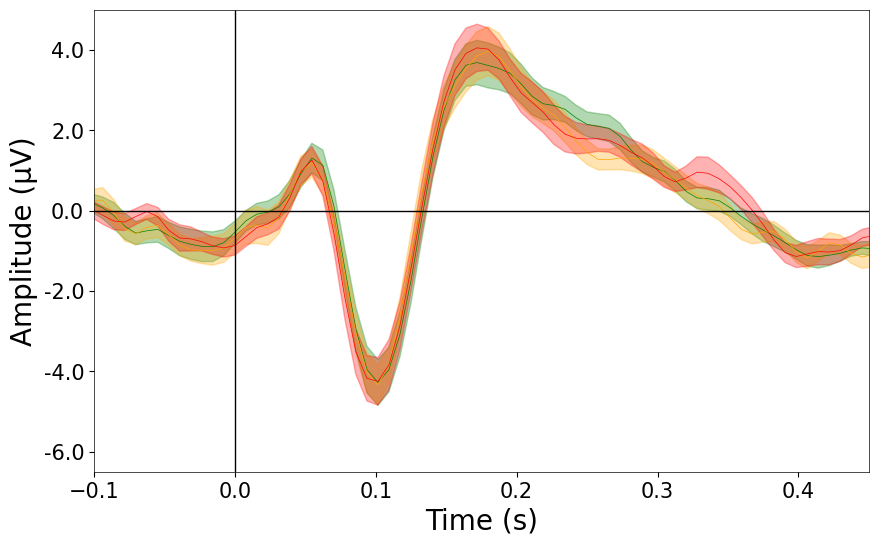

In [102]:
#plot ALL ERPs by map per period
ch_idx = ch_index(['Fz'])
period= 'pre'

mean_all, sem_all = find_mean_sem_eps(epochs_df_all, ch_idx)
mean_inv, sem_inv = find_mean_sem_eps(epochs_df_inv.query(f'period == "{period}"'), ch_idx)
mean_shinv, sem_shinv = find_mean_sem_eps(epochs_df_shinv.query(f'period == "{period}"'), ch_idx)
mean_norm, sem_norm = find_mean_sem_eps(epochs_df_norm.query(f'period == "{period}"'), ch_idx)

plt.figure(figsize=(10, 6))

#plot_mean_sem(erp_times, mean_all, sem_all, color='black', label='all')
plot_mean_sem(erp_times, mean_inv, sem_inv, color='green', label='inv')
plot_mean_sem(erp_times, mean_shinv, sem_shinv, color='orange', label='shinv')
plot_mean_sem(erp_times, mean_norm, sem_norm, color='red', label='norm')

config_erp_plot()

# plt.title(f'ERP by map, {period}', fontsize=axis_fontsize)
# plt.savefig(f'./figs/erp_by_map_{period}.svg')


## Firsts by previous map
(this uses a csv file with info about all the keystrokes. Technically the previous section, first by map, can also be plotted using this info but the different methods should be equivalent)

In [114]:
mapchange_path = '../analysis_error/mapchange_csv_corrected_since_bymap'

epochs_df_prevmap = pd.DataFrame(columns = ['subject', 'period'])

for idx, row in epochs_df_all.iterrows():
    sub = row['subject']
    period = row['period']
    mapchange_file = os.path.join(mapchange_path, f'mapchange_keystrokes_{period}_{sub}.csv')
    mapchange_df = pd.read_csv(mapchange_file)

    #firsts by current map
    firstinv_values = mapchange_df.query("type == 'first' & map == 'inv'")['keystroke_idx'].values
    firstshinv_values = mapchange_df.query("type == 'first' & map == 'shinv'")['keystroke_idx'].values
    firstnorm_values = mapchange_df.query("type == 'first' & map == 'norm'")['keystroke_idx'].values

    eps_firstinv = row['epochs'][firstinv_values, :, :] 
    eps_firstshinv = row['epochs'][firstshinv_values, :, :] 
    eps_firstnorm = row['epochs'][firstnorm_values, :, :] 

    #firsts by prev map
    firstinvprev_values = mapchange_df.query("type == 'first' & prev_map == 'inv'")['keystroke_idx'].values
    firstshinvprev_values = mapchange_df.query("type == 'first' & prev_map == 'shinv'")['keystroke_idx'].values
    firstnormprev_values = mapchange_df.query("type == 'first' & prev_map == 'norm'")['keystroke_idx'].values


    eps_firstinvprev = row['epochs'][firstinvprev_values, :, :] 
    eps_firstshinvprev = row['epochs'][firstshinvprev_values, :, :] 
    eps_firstnormprev = row['epochs'][firstnormprev_values, :, :] 

    df_sub = pd.DataFrame({
        'subject': sub,
        'period': period,
        'firstinv'  :[eps_firstinv], 
        'firstshinv': [eps_firstshinv],
        'firstnorm': [eps_firstnorm],
        'firstinvprev'  :[eps_firstinvprev], 
        'firstshinvprev': [eps_firstshinvprev],
        'firstnormprev': [eps_firstnormprev],
    })

    epochs_df_prevmap = pd.concat([epochs_df_prevmap, df_sub])

# epochs_df_all.columns

## Fig S7: Comparing first and others by map

In [119]:
mapchange_path = '../analysis_error/mapchange_csv_corrected_since_bymap'

epochs_df_prevmap = pd.DataFrame(columns = ['subject', 'period'])

for idx, row in epochs_df_all.iterrows():
    sub = row['subject']
    period = row['period']
    mapchange_file = os.path.join(mapchange_path, f'mapchange_keystrokes_{period}_{sub}.csv')
    mapchange_df = pd.read_csv(mapchange_file)

    #firsts by current map
    firstinv_values = mapchange_df.query("type == 'first' & map == 'inv'")['keystroke_idx'].values
    firstshinv_values = mapchange_df.query("type == 'first' & map == 'shinv'")['keystroke_idx'].values
    firstnorm_values = mapchange_df.query("type == 'first' & map == 'norm'")['keystroke_idx'].values

    eps_firstinv = row['epochs'][firstinv_values, :, :] 
    eps_firstshinv = row['epochs'][firstshinv_values, :, :] 
    eps_firstnorm = row['epochs'][firstnorm_values, :, :] 

    #firsts by prev map
    firstinvprev_values = mapchange_df.query("type == 'first' & prev_map == 'inv'")['keystroke_idx'].values
    firstshinvprev_values = mapchange_df.query("type == 'first' & prev_map == 'shinv'")['keystroke_idx'].values
    firstnormprev_values = mapchange_df.query("type == 'first' & prev_map == 'norm'")['keystroke_idx'].values

    eps_firstinvprev = row['epochs'][firstinvprev_values, :, :] 
    eps_firstshinvprev = row['epochs'][firstshinvprev_values, :, :] 
    eps_firstnormprev = row['epochs'][firstnormprev_values, :, :] 

    try:
        
        #others by current map
        otherinv_values = mapchange_df.query("type == 'other' & map == 'inv'")['keystroke_idx'].values
        othershinv_values = mapchange_df.query("type == 'other' & map == 'shinv'")['keystroke_idx'].values
        othernorm_values = mapchange_df.query("type == 'other' & map == 'norm'")['keystroke_idx'].values

        #filter out indices that are out of range (erp window extends beyond end of recording)
        otherinv_values = otherinv_values[np.where(otherinv_values < row['epochs'].shape[0])]
        othershinv_values = othershinv_values[np.where(othershinv_values < row['epochs'].shape[0])]
        othernorm_values = othernorm_values[np.where(othernorm_values < row['epochs'].shape[0])]

        #index the epochs that we care about
        eps_otherinv = row['epochs'][otherinv_values, :, :] 
        eps_othershinv = row['epochs'][othershinv_values, :, :] 
        eps_othernorm = row['epochs'][othernorm_values, :, :] 

        #others by prev map
        otherinvprev_values = mapchange_df.query("type == 'other' & prev_map == 'inv'")['keystroke_idx'].values
        othershinvprev_values = mapchange_df.query("type == 'other' & prev_map == 'shinv'")['keystroke_idx'].values
        othernormprev_values = mapchange_df.query("type == 'other' & prev_map == 'norm'")['keystroke_idx'].values

            # Filter valid indices
        otherinvprev_values = otherinvprev_values[np.where(otherinvprev_values < row['epochs'].shape[0])]
        othershinvprev_values = othershinvprev_values[np.where(othershinvprev_values < row['epochs'].shape[0])]
        othernormprev_values = othernormprev_values[np.where(othernormprev_values < row['epochs'].shape[0])]

        eps_otherinvprev = row['epochs'][otherinvprev_values, :, :] 
        eps_othershinvprev = row['epochs'][othershinvprev_values, :, :] 
        eps_othernormprev = row['epochs'][othernormprev_values, :, :] 
    
    except IndexError:
        print(f'index error at {sub}{period}')
        continue


    df_sub = pd.DataFrame({
        'subject': sub,
        'period': period,

        'firstinv'  :[eps_firstinv], 
        'firstshinv': [eps_firstshinv],
        'firstnorm': [eps_firstnorm],

        'firstinvprev'  :[eps_firstinvprev], 
        'firstshinvprev': [eps_firstshinvprev],
        'firstnormprev': [eps_firstnormprev],

        'otherinv'  :[eps_otherinv], 
        'othershinv': [eps_othershinv],
        'othernorm': [eps_othernorm],

        'otherinvprev'  :[eps_otherinvprev], 
        'othershinvprev': [eps_othershinvprev],
        'othernormprev': [eps_othernormprev]

        
    })

    epochs_df_prevmap = pd.concat([epochs_df_prevmap, df_sub])

# epochs_df_all.columns

In [120]:
pairs =[ ('firstinv', 'otherinv'),
        ('firstshinv', 'othershinv'),
        ('firstnorm', 'othernorm'), 
        
        ('firstinvprev', 'otherinvprev'),
        ('firstshinvprev', 'othershinvprev'),
        ('firstnormprev', 'othernormprev')
]

first_ev_ave = pd.DataFrame()

for pair in pairs: 
    col_1 = 'ev_'+pair[0]
    col_2 = 'ev_'+pair[1]
    first_ev_ave = find_evokeds(epochs_df_prevmap, column_to_ave=pair[0], ev_col_name=col_1)
    first_ev_ave = find_evokeds(epochs_df_prevmap, column_to_ave=pair[1], ev_col_name=col_2)
    first_ev_ave['diff_'+pair[0]+"_"+pair[1]] = first_ev_ave[col_1] - first_ev_ave[col_2]


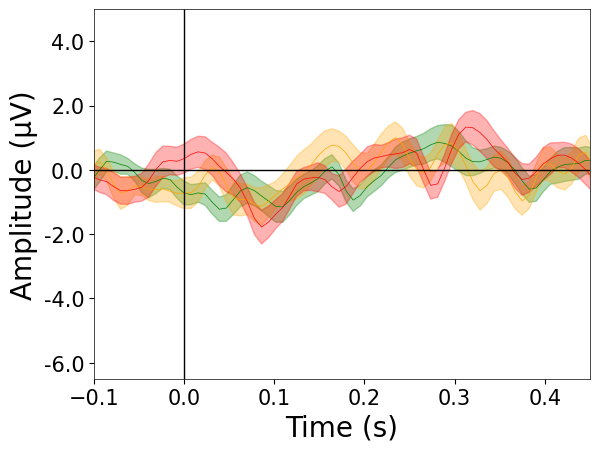

In [121]:
period = 'post'
ch_idx = ch_index(['Fz'])

mean_firstinv, sem_firstinv = find_mean_sem_evs(first_ev_ave.query(f'period == "{period}"'), ch_idx=ch_idx, col_to_ave='diff_firstinv_otherinv')
mean_firstshinv, sem_firstshinv = find_mean_sem_evs(first_ev_ave.query(f'period == "{period}"'), ch_idx=ch_idx, col_to_ave='diff_firstshinv_othershinv')
mean_firstnorm, sem_firstnorm = find_mean_sem_evs(first_ev_ave.query(f'period == "{period}"'), ch_idx=ch_idx, col_to_ave='diff_firstnorm_othernorm')

plot_mean_sem(erp_times, mean_firstinv, sem_firstinv, color = 'green', label = 'INV')
plot_mean_sem(erp_times, mean_firstshinv, sem_firstshinv, color = 'orange', label = 'SH-INV')
plot_mean_sem(erp_times, mean_firstnorm, sem_firstnorm, color = 'red', label = 'NORM')

config_erp_plot()
#plt.title(f'Firsts-other diffs by current map, {period}')
# plt.savefig(f'./figs/diffs_enter_bymap_{period}.svg')

## Fig 6E: Bootstrapping differences by map

In [132]:
def subset_epochs_custom(epochs_df, n_epochs, ep_col = 'epochs', ave = False):
    """ 
    Takes a subset of each epoch type
    """
    if ave:
        epochs_sub = np.mean([epoch[np.random.choice(epoch.shape[0], n_epochs, replace=True), :, :]
                                        for epoch in epochs_df[ep_col]], axis = 1)
    else:
        epochs_sub =[epoch[np.random.choice(epoch.shape[0], n_epochs, replace=True), :, :]
                                        for epoch in epochs_df[ep_col]]
        
    epochs_df_new = epochs_df.copy()
    epochs_df_new[ep_col] = [epochs_sub[i] for i in range(epochs_df.shape[0])]

    return epochs_df_new

def ci95(arr, axis):
    lower_bound = np.percentile(arr, 2.5, axis = axis)
    upper_bound = np.percentile(arr, 97.5, axis = axis)

    return lower_bound, upper_bound


def bootstrap_fo_diffs_2(epochs_df_1, epochs_df_2, period, time_to_plot, n_iter = 200, n_samp = 100, ep_col = 'epochs'):
    """ 
    epochs_df_1, epochs_df_2:epochs to compare.Dataframe with columns 'subject', 'period', 'musician', 'epochtype', 'epochs'
    period: 'pre' or 'post' training
    time_to_plot: timepoint to bootstrap
    n_iter: number of bootstrap iterations
    n_samp: number of epochs from each epoch df to sample for each iteration
    ---
    Returns: distribution of means of the bootstrapped differences between epochs_df_1 and epochs_df_2 at all channels
        shape n_iter x n_channels
    """

    diffs_fo_boot = []

    for i in range(n_iter):

        #take a random sample of epochs from each df
        epochs_df_firsts_sub = subset_epochs_custom(epochs_df_1, n_samp, ep_col)
        epochs_df_others_sub = subset_epochs_custom(epochs_df_2, n_samp, ep_col)

        #find the mean of each sample
        epochs_df_firsts_sub['evokeds'] =  epochs_df_firsts_sub['epochs'].apply(lambda x: np.mean(x, axis=0)) 
        epochs_df_others_sub['evokeds'] = epochs_df_others_sub['epochs'].apply(lambda x: np.mean(x, axis = 0))

        #calculate diff between mean of firsts and mean of others
        df_diff_sub = epochs_df_firsts_sub[['subject', 'period']].copy()
        df_diff_sub['diff'] = epochs_df_firsts_sub['evokeds'] - epochs_df_others_sub['evokeds']

        #retain the time index of time_to_plot
        time_idx = time_index_custom([time_to_plot], erp_times)

        #isolate the rows of df for pre-training
        #extract diff values for each suject, retains the 64 EEG channels and the timepoint of interest
        diffs_fo_sub = np.stack(df_diff_sub.query(f"period =='{period}'")['diff'].values)[:, :64, time_idx].squeeze()
        diffs_fo_boot.append(diffs_fo_sub)

    diffs_fo_boot = np.stack(diffs_fo_boot)
    diffs_fo_boot_mean = np.mean(diffs_fo_boot, axis = 1) #average over subjects over each iteration

    return diffs_fo_boot_mean


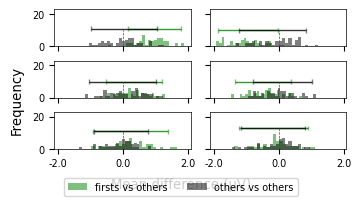

In [136]:
maps_list = ['inv', 'shinv', 'norm']
periods = ['pre', 'post']

ch_to_plot = 'Fz'
ch_idx = ch_index([ch_to_plot])
n_bins = 25
n_iter = 50 # 1000
n_samp = 30
time_to_plot = 0.05

fig, axes = plt.subplots(len(maps_list), len(periods), figsize=(3.5, 1.9), 
                         sharex=True, sharey=True, constrained_layout=True)

for i, maps in enumerate(maps_list):
    for j, period in enumerate(periods):
        ax = axes[i, j]

        # --- Prepare data ---
        epochs_df_first = epochs_df_prevmap[['subject', 'period', f'first{maps}']].rename(
            columns={f'first{maps}': 'epochs'}
        )
        epochs_df_other = epochs_df_prevmap[['subject', 'period', f'other{maps}']].rename(
            columns={f'other{maps}': 'epochs'}
        )

        # first vs others bootstrap
        diffs_fo_boot_mean = bootstrap_fo_diffs_2(
            epochs_df_first, epochs_df_other,
            period,
            time_to_plot=time_to_plot,
            n_iter=n_iter,
            n_samp=n_samp
        )
        ci_l, ci_u = ci95(diffs_fo_boot_mean, axis=0)

        # null distribution
        diffs_fo_boot_mean_null = bootstrap_fo_diffs_2(
            epochs_df_other, epochs_df_other,
            period,
            time_to_plot=time_to_plot,
            n_iter=n_iter,
            n_samp=n_samp
        )
        ci_l_null, ci_u_null = ci95(diffs_fo_boot_mean_null, axis=0)

        # --- Plot histogram ---
        counts_firsts, _, _ = ax.hist(diffs_fo_boot_mean[:, ch_idx], bins=n_bins,
                                      color='green', label='firsts vs others', alpha=0.5)
        counts_others, _, _ = ax.hist(diffs_fo_boot_mean_null[:, ch_idx], bins=n_bins,
                                      color='black', label='others vs others', alpha=0.5)

        bar_ypos = max(np.max(counts_firsts), np.max(counts_others)) + 4
        bracketsize = 1.5

        # CI95 bars
        ax.hlines(bar_ypos, ci_l[ch_idx], ci_u[ch_idx], color='green', linewidth=1, alpha=0.8)
        ax.vlines([ci_l[ch_idx], ci_u[ch_idx]], bar_ypos - bracketsize, bar_ypos + bracketsize,
                  color='green', linewidth=1, alpha=0.5)

        ax.hlines(bar_ypos, ci_l_null[ch_idx], ci_u_null[ch_idx], color='black', linewidth=1, alpha=0.8)
        ax.vlines([ci_l_null[ch_idx], ci_u_null[ch_idx]], bar_ypos - bracketsize, bar_ypos + bracketsize,
                  color='black', linewidth=1, alpha=0.5)

        # Zero line
        ax.vlines(0, 0, bar_ypos, color='red', linestyle='--')

        ax.set_ylim(0, bar_ypos+10)

        # Formatting
        # if i == len(periods)-1:  # bottom row: x-axis
        #     ax.set_xlabel('Mean difference (µV)')
        #     ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x * 1e6:.1f}'))
        # if j == 0:  # first column: y-axis
        #     ax.set_ylabel('Frequency')

        # ax.set_title(f'{maps}, {period}')


handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x * 1e6:.1f}'))  # Convert to µV


fig.supxlabel('Mean difference (µV)')
fig.supylabel('Frequency')

# plt.tight_layout()
# fig.tight_layout(rect=[0, 0.1, 1, 1])  # leave space at bottom for legend
plt.savefig(f'./figures/bootstrap_bymap_{time_to_plot}.svg', transparent = True)